In [1]:
# Parameters cell for papermill launching
work_dir <- "./intermediate_branch_data/Nov-2023-log10"

In [2]:
# Parameters
work_dir = "./intermediate_branch_data/Nov-2023-log10-DO-update-correct"


In [3]:
# Change to working directory
setwd(work_dir)

# Confirmation of change directory
getwd()

[1] "/home/sfgary/ICON-ModEx_Open_Manuscript/fig03-model-score-evolution/intermediate_branch_data/Nov-2023-log10-DO-update-correct"

In [4]:
system("conda env list", intern=TRUE)

[1] "# conda environments:"                                
[2] "#"                                                    
[3] "base                  *  /home/sfgary/pw/.miniconda3c"
[4] ""

In [5]:
library(tidyverse)
# Capitalization matters!
library(ggExtra)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Scatter plot  
- using new merged dataset to create scatter plot
- add kernel densities to the plots (along the side)

In [6]:
#some filtering/mutating first 
combods_split <- read_csv("ICON-ModEx_Combined_Predicted_Observed_Respiration_Rates.csv", na = c(-9999, "N/A", "NA", NA)) %>%
#remova Na's
  #split data set into "hot" and "cold" spots
  mutate(ds_split = ifelse(Log_Observed_Normalized_Respiration_Rate > 2.7, "500+",                         ifelse(Log_Observed_Normalized_Respiration_Rate < 2.7, "500-", "500-") )) %>% 
  
#clasifying by quadrant (hot, cold, misclass hot, misclass cold) by year
# Need to get rid of the year because we are working year-by-year
  mutate(ds_quadrant23 =                                                    ifelse(Log_Observed_Normalized_Respiration_Rate > 2.7 & Log_Predicted_Normalized_Respiration_Rate > 2.7 , "hs23",
  ifelse(Log_Observed_Normalized_Respiration_Rate > 2.7 & Log_Predicted_Normalized_Respiration_Rate < 2.7 , "misclass_hs23",                                                                                              
ifelse(Log_Observed_Normalized_Respiration_Rate < 2.7 & Log_Predicted_Normalized_Respiration_Rate < 2.7 , "cs23",    
ifelse(Log_Observed_Normalized_Respiration_Rate < 2.7 & Log_Predicted_Normalized_Respiration_Rate > 2.7 , "misclass_cs23", NA)))) )

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


Rows: 684 Columns: 22


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Sample_ID
dbl (20): Sample_Longitude_obs, Sample_Latitude_obs, Mean_Temp_Deg_C, pH, Me...
lgl  (1): Mean_DO_percent_saturation



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Scatter plot in log-log space
 - needs to have kernel density plots on y and x axis
 - needs use log data
 - needs to have overall line, line for above 500, below 500, and R^2 values for all three
 - facet wrap or color dots by iteration (first versus last)
 
 - right now s19s iteration, but want OG 0th iteration

In [7]:
#add in lm's
#run 3 lm up here, then extract R^2, then call into annotate 
lm_all_final <- lm(Log_Predicted_Normalized_Respiration_Rate ~ Log_Observed_Normalized_Respiration_Rate, combods_split)
summary(lm_all_final)

lm_sup_final <- lm(Log_Predicted_Normalized_Respiration_Rate ~ Log_Observed_Normalized_Respiration_Rate, combods_split %>% filter(ds_split == "500+"))
summary(lm_sup_final)

lm_sub_final <- lm(Log_Predicted_Normalized_Respiration_Rate ~ Log_Observed_Normalized_Respiration_Rate, combods_split %>% filter(ds_split == "500-"))
summary(lm_sub_final)



fullscatter_lastiteration <- 
  combods_split %>% ggplot(aes(abs(Log_Observed_Normalized_Respiration_Rate ),
                      abs(Log_Predicted_Normalized_Respiration_Rate) #)) + #
                      ,  color =  ds_split))+ 
#to see R^2 for above/below thresholds, remove color grouping above and use stat poly eq fx (below)
  geom_point(color = "darkgrey", size = 3, pch = 21) + 
    geom_vline (xintercept = 2.7, linetype = "dashed", color="grey") + 
    geom_hline (yintercept = 2.7, linetype = "dashed", color="dark grey") + #not a clear threshold 
      geom_abline (linetype = "longdash", color="black") + #not a clear threshold

# Required by ggextra, fails to import above. Where are the other lines (blue and red) plotted?
     #ggpmisc::stat_poly_line(color = "black", alpha = 0.5) + #overall best fit


# stat_poly_eq(use_label(c( "R2"))) + #remove hashtag to see R^2 of log500 split
 
    geom_smooth( aes(abs(Log_Observed_Normalized_Respiration_Rate ), #above/below threshold best fit
                      abs(Log_Predicted_Normalized_Respiration_Rate),
                      color =  ds_split), method = "lm", alpha = 0.2) + 
    geom_smooth( aes(abs(Log_Observed_Normalized_Respiration_Rate ), #above/below threshold best fit
                      abs(Log_Predicted_Normalized_Respiration_Rate)), method = "lm", alpha = 0.2,
                      color =  "black") +
  xlab("log10(Observed rates)") + 
  ylab("log10(Predicted rates)") + 
scale_shape_manual(values = c(21, 16)) + #shape or color by iteration
  scale_color_manual(values = c( "lightblue", "maroon")) +

annotate('text', label = str_c('R^2 == ', round(summary(lm_all_final)$r.squared, 2)), parse = T, x = 3.5, y = 0.75, size = 5, family = 'serif', color = "black")+
annotate('text', label = str_c('R^2 == ', round(summary(lm_sub_final)$r.squared, 2)), parse = T, x = 3.5, y = 0.5, size = 5, family = 'serif', color="lightblue")+
annotate('text', label = str_c('R^2 == ', round(summary(lm_sup_final)$r.squared, 2)), parse = T, x = 3.5, y = 0.25, size = 5, family = 'serif',  color="maroon")+

annotate('text', label = str_c('RMSE == ', round(sqrt(mean(lm_all_final$residuals^2)), 2)), parse = T, x = 2.0, y = 0.72, size = 5, family = 'serif', color = "black")+
annotate('text', label = str_c('RMSE == ', round(sqrt(mean(lm_sub_final$residuals^2)), 2)), parse = T, x = 2.0, y = 0.47, size = 5, family = 'serif', color = "lightblue")+
annotate('text', label = str_c('RMSE == ', round(sqrt(mean(lm_sup_final$residuals^2)), 2)), parse = T, x = 2.0, y = 0.22, size = 5, family = 'serif', color = "maroon")+

annotate('text', label = str_extract(work_dir, '[^/]+$'), x = 1.6, y = 4, size = 5, family = 'serif',  color="black")+

  lims(y = c(0,4), x = c(0,4)) + 
  theme_classic() +
   theme(text = element_text(size = 16, family = 'serif'), 
         legend.position = 0)

#adding density plots on axes
 histograms <- ggExtra::ggMarginal(fullscatter_lastiteration, fill = "lightgrey")
 
# Original plot save in tidy
ggsave(filename = "./scatter.png", plot = histograms, width = 6, height = 6, dpi = 300)  
#ggsave(filename = "./scatter.pdf", plot = fullscatter_lastiteration, width = 6, height = 6, units="in", dpi = 300, device="pdf")  
# View plot inline
#histograms

# Alternative in base
#png("./scatter.png")
#print(histograms)
#print(fullscatter_lastiteration)
#dev.off()


Call:
lm(formula = Log_Predicted_Normalized_Respiration_Rate ~ Log_Observed_Normalized_Respiration_Rate, 
    data = combods_split)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8260 -0.1800 -0.0363  0.1710  1.1483 

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                               1.58920    0.01712   92.82   <2e-16
Log_Observed_Normalized_Respiration_Rate  0.42866    0.01029   41.66   <2e-16
                                            
(Intercept)                              ***
Log_Observed_Normalized_Respiration_Rate ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2625 on 682 degrees of freedom
Multiple R-squared:  0.7179,	Adjusted R-squared:  0.7175 
F-statistic:  1736 on 1 and 682 DF,  p-value: < 2.2e-16



Call:
lm(formula = Log_Predicted_Normalized_Respiration_Rate ~ Log_Observed_Normalized_Respiration_Rate, 
    data = combods_split %>% filter(ds_split == "500+"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.99171 -0.05417  0.07124  0.13804  0.45871 

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                               -0.9284     0.5432  -1.709   0.0908
Log_Observed_Normalized_Respiration_Rate   1.2238     0.1619   7.561 2.92e-11
                                            
(Intercept)                              .  
Log_Observed_Normalized_Respiration_Rate ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2888 on 92 degrees of freedom
Multiple R-squared:  0.3832,	Adjusted R-squared:  0.3765 
F-statistic: 57.17 on 1 and 92 DF,  p-value: 2.92e-11



Call:
lm(formula = Log_Predicted_Normalized_Respiration_Rate ~ Log_Observed_Normalized_Respiration_Rate, 
    data = combods_split %>% filter(ds_split == "500-"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.38166 -0.15176 -0.07268  0.10778  1.16090 

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                               1.73476    0.01830   94.79   <2e-16
Log_Observed_Normalized_Respiration_Rate  0.26449    0.01538   17.20   <2e-16
                                            
(Intercept)                              ***
Log_Observed_Normalized_Respiration_Rate ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2232 on 588 degrees of freedom
Multiple R-squared:  0.3346,	Adjusted R-squared:  0.3335 
F-statistic: 295.7 on 1 and 588 DF,  p-value: < 2.2e-16


`geom_smooth()` using formula = 'y ~ x'


`geom_smooth()` using formula = 'y ~ x'


`geom_smooth()` using formula = 'y ~ x'


`geom_smooth()` using formula = 'y ~ x'


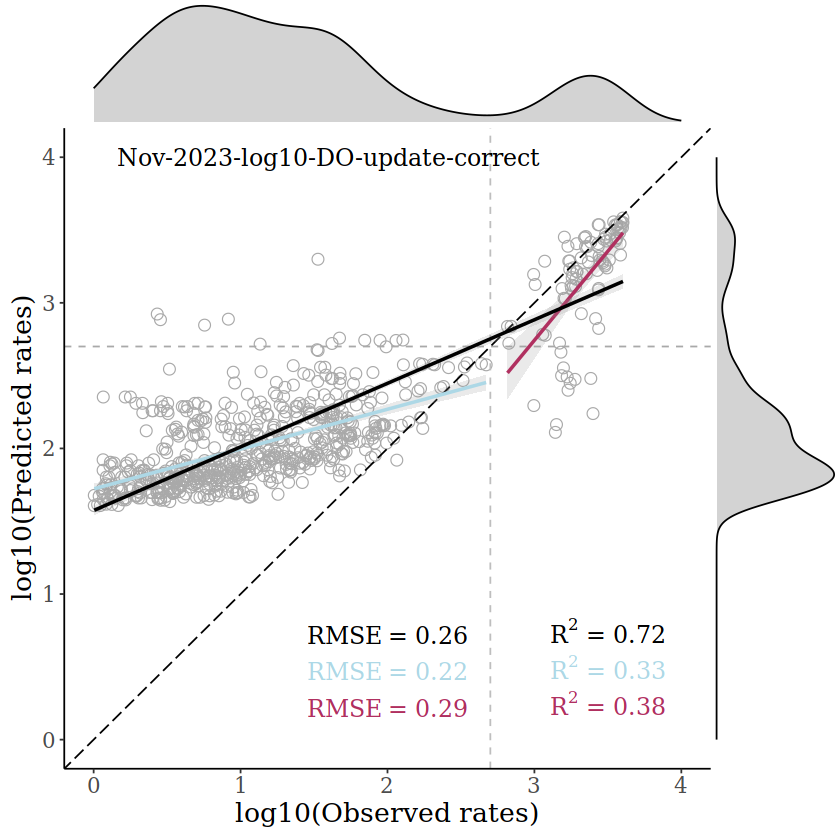

In [8]:
# Display figure inline if necessary
histograms

## Observations vs. predicted values scatter plots in normal space

In [9]:
#add in lm's
# Linear model is what generates the R^2
#run 3 lm up here, then extract R^2, then call into annotate 
lm_all_final <- lm(Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg ~ Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs, combods_split)
summary(lm_all_final)

lm_sup_final <- lm(Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg ~ Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs, combods_split %>% filter(ds_split == "500+"))
summary(lm_sup_final)

lm_sub_final <- lm(Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg ~ Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs, combods_split %>% filter(ds_split == "500-"))
summary(lm_sub_final)



fullscatter_lastiteration_no_log <- 
  combods_split %>% ggplot(aes(abs(Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs ),
                      abs(Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg) #)) + #
                      ,  color =  ds_split))+ 
#to see R^2 for above/below thresholds, remove color grouping above and use stat poly eq fx (below)
  geom_point(color = "darkgrey", size = 3, pch = 21) + 
    geom_vline (xintercept = 10^2.7, linetype = "dashed", color="grey") + 
    geom_hline (yintercept = 10^2.7, linetype = "dashed", color="dark grey") + #not a clear threshold 
      geom_abline (linetype = "longdash", color="black") + #not a clear threshold

# Required by ggextra, fails to import above. Where are the other lines (blue and red) plotted?
     #ggpmisc::stat_poly_line(color = "black", alpha = 0.5) + #overall best fit


# stat_poly_eq(use_label(c( "R2"))) + #remove hashtag to see R^2 of log500 split
 
    geom_smooth( aes(abs(Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs ), #above/below threshold best fit
                      abs(Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg),
                      color =  ds_split), method = "lm", alpha = 0.2) + 
    geom_smooth( aes(abs(Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs ), #above/below threshold best fit
                      abs(Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg)), method = "lm", alpha = 0.2,
                      color =  "black") +
  xlab("log10(Observed rates)") + 
  ylab("log10(Predicted rates)") + 
scale_shape_manual(values = c(21, 16)) + #shape or color by iteration
  scale_color_manual(values = c( "lightblue", "maroon")) +

annotate('text', label = str_c('R^2 == ', round(summary(lm_all_final)$r.squared, 2)), parse = T, x = 3500, y = 1500, size = 5, family = 'serif', color = "black")+
annotate('text', label = str_c('R^2 == ', round(summary(lm_sub_final)$r.squared, 2)), parse = T, x = 3500, y = 1200, size = 5, family = 'serif', color="lightblue")+
annotate('text', label = str_c('R^2 == ', round(summary(lm_sup_final)$r.squared, 2)), parse = T, x = 3500, y = 1000, size = 5, family = 'serif',  color="maroon")+
    
annotate('text', label = str_c('RMSE == ', round(sqrt(mean(lm_all_final$residuals^2)), 2)), parse = T, x = 1000.0, y = 3500, size = 5, family = 'serif', color = "black")+
annotate('text', label = str_c('RMSE == ', round(sqrt(mean(lm_sub_final$residuals^2)), 2)), parse = T, x = 1000.0, y = 3200, size = 5, family = 'serif', color = "lightblue")+
annotate('text', label = str_c('RMSE == ', round(sqrt(mean(lm_sup_final$residuals^2)), 2)), parse = T, x = 1000.0, y = 3000, size = 5, family = 'serif', color = "maroon")+

annotate('text', label = str_extract(work_dir, '[^/]+$'), x = 1700.0, y = 4000.0, size = 5, family = 'serif',  color="black")+

  lims(y = c(0,4000), x = c(0,4000)) + 
  theme_classic() +
   theme(text = element_text(size = 16, family = 'serif'), 
         legend.position = 0)

#adding density plots on axes
 histograms_no_log <- ggExtra::ggMarginal(fullscatter_lastiteration_no_log, fill = "lightgrey")
 
# Original plot save in tidy
ggsave(filename = "./scatter_no_log.png", plot = histograms_no_log, width = 6, height = 6, dpi = 300)  


Call:
lm(formula = Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg ~ 
    Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs, 
    data = combods_split)

Residuals:
     Min       1Q   Median       3Q      Max 
-1864.70   -39.41    32.07    50.56  1833.21 

Coefficients:
                                                             Estimate
(Intercept)                                                -102.73855
Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs    0.75993
                                                           Std. Error t value
(Intercept)                                                  11.69048  -8.788
Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs    0.01213  62.646
                                                           Pr(>|t|)    
(Intercept)                                                  <2e-16 ***
Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 


Call:
lm(formula = Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg ~ 
    Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs, 
    data = combods_split %>% filter(ds_split == "500+"))

Residuals:
     Min       1Q   Median       3Q      Max 
-1638.02  -440.03   -96.61   461.88  1802.54 

Coefficients:
                                                            Estimate Std. Error
(Intercept)                                                202.82426  206.44395
Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs   0.86964    0.07953
                                                           t value Pr(>|t|)    
(Intercept)                                                  0.982    0.328    
Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs  10.935   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 699.6 on 92 degrees of freedom
Multiple R-squared:  0.5652,	Adjusted R-squared:  0.5605 
F-statistic


Call:
lm(formula = Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg ~ 
    Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs, 
    data = combods_split %>% filter(ds_split == "500-"))

Residuals:
     Min       1Q   Median       3Q      Max 
-1857.26   -19.02    38.19    52.08   174.18 

Coefficients:
                                                            Estimate Std. Error
(Intercept)                                                -103.8096     5.7644
Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs    0.9491     0.1039
                                                           t value Pr(>|t|)    
(Intercept)                                                -18.009   <2e-16 ***
Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs   9.133   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 122.4 on 588 degrees of freedom
Multiple R-squared:  0.1242,	Adjusted R-squared:  0.1227 
F-statisti

`geom_smooth()` using formula = 'y ~ x'


Warning message:
“Removed 2 rows containing non-finite values (`stat_smooth()`).”


`geom_smooth()` using formula = 'y ~ x'


Warning message:
“Removed 2 rows containing non-finite values (`stat_smooth()`).”


`geom_smooth()` using formula = 'y ~ x'


Warning message:
“Removed 2 rows containing non-finite values (`stat_smooth()`).”


`geom_smooth()` using formula = 'y ~ x'


Warning message:
“Removed 2 rows containing non-finite values (`stat_smooth()`).”


Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


In [10]:
#fullscatter_lastiteration_no_log
#histograms_no_log